In [1]:
# Clone the repository
!git clone https://github.com/richardsun-voyager/UAFTC.git
%cd UAFTC
!ls

Cloning into 'UAFTC'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 89 (delta 37), reused 66 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 19.24 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/UAFTC
appendix_2020.pdf				      data_processor.py
args						      derivatives.pdf
attention_score_binary_classification.ipynb	      dynamic_lstm.py
attn_model.py					      helper.py
attn_neural_classification_interpret_synthetic.ipynb  imgs
data						      README.md


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Check GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create directories
!mkdir -p data/custom
!mkdir -p results/sst
!mkdir -p results/custom

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [3]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Attention Classifier Model WITH DROPOUT
class AttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, lambda_scale, dropout=0.5):
        super(AttentionClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.V = nn.Parameter(torch.randn(embed_dim))  # Context vector
        self.W = nn.Parameter(torch.randn(embed_dim))  # Linear layer weight
        self.lambda_scale = lambda_scale

        # Add dropout layer (as in the paper)
        self.dropout = nn.Dropout(dropout)

        # Initialize with uniform distribution [-0.1, 0.1]
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.uniform_(self.V, -0.1, 0.1)
        nn.init.uniform_(self.W, -0.1, 0.1)

    def forward(self, x, return_attention=False):
        # x: [batch_size, seq_len]
        embeds = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Apply dropout to embeddings (during training)
        embeds = self.dropout(embeds)

        # Compute attention scores
        attention_scores = torch.matmul(embeds, self.V) / self.lambda_scale

        # Compute attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Weighted sum
        context = torch.sum(embeds * attention_weights.unsqueeze(-1), dim=1)

        # Compute polarity score
        output = torch.matmul(context, self.W)

        if return_attention:
            token_polarity = torch.matmul(embeds, self.W)
            return output, attention_weights, attention_scores, token_polarity

        return output

print("Model defined with dropout (p=0.5)")

Model defined with dropout (p=0.5)


Helper Functions

In [4]:
def build_vocab(data, min_freq=1):
    """Build vocabulary from data"""
    word_counts = Counter()
    for text, _ in data:
        words = text.split()
        word_counts.update(words)

    # Use explicit PAD and UNK tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

def text_to_indices(text, vocab, max_len=50):
    """Convert text to indices"""
    words = text.split()[:max_len]
    indices = [vocab.get(word, vocab['<UNK>']) for word in words]
    # Pad to fixed length
    while len(indices) < max_len:
        indices.append(vocab['<PAD>'])
    return indices

def train_model(model, train_data, dev_data, vocab, num_epochs, device, verbose=False):
    """Train the model"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)

    best_dev_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        random.shuffle(train_data)

        for text, label in train_data:
            indices = text_to_indices(text, vocab)
            x = torch.LongTensor([indices]).to(device)
            y = torch.FloatTensor([label]).to(device)

            optimizer.zero_grad()
            output = model(x)

            y_scaled = 2 * y - 1
            loss = criterion(output * y_scaled, torch.ones_like(output))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = (torch.sigmoid(output) > 0.5).float()
            correct += (pred == y).sum().item()
            total += 1

        train_acc = correct / total
        dev_acc = evaluate_model(model, dev_data, vocab, device)

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/total:.4f}, Train: {train_acc:.4f}, Dev: {dev_acc:.4f}")

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

    return best_dev_acc

def evaluate_model(model, data, vocab, device):
    """Evaluate the model"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for text, label in data:
            indices = text_to_indices(text, vocab)
            x = torch.LongTensor([indices]).to(device)
            y = torch.FloatTensor([label]).to(device)

            output = model(x)
            pred = (torch.sigmoid(output) > 0.5).float()
            correct += (pred == y).sum().item()
            total += 1

    return correct / total

print("Helper functions defined")

Helper functions defined


PART 1: Validate on SST Dataset

In [5]:
import pickle
import numpy as np

def load_sst_data(data_dir='data/sst'):
    """Load SST dataset from pickle files"""

    print("Loading SST from pickle files...")

    # Load vocabulary - it's a list where vocab[0] contains the words
    with open(f'{data_dir}/vocab/local_dict.pkl', 'rb') as f:
        vocab_container = pickle.load(f)

    # Extract actual vocabulary (first element)
    if isinstance(vocab_container, list) and len(vocab_container) > 0:
        vocab_list = vocab_container[0]  # The actual word list
    else:
        vocab_list = vocab_container

    # Create index to word mapping
    idx2word = {i: word for i, word in enumerate(vocab_list)}
    print(f"  Vocabulary: {len(vocab_list)} words")

    def load_pkl_data(pkl_path):
        with open(pkl_path, 'rb') as f:
            data_zip = pickle.load(f)

        # Convert zip object to list
        data = list(data_zip)

        processed = []
        for item in data:
            if len(item) == 2:
                seq, label = item

                # Convert indices to words
                words = []
                for idx in seq:
                    if idx == 0:  # Skip padding
                        continue
                    word = idx2word.get(idx, '<UNK>')
                    words.append(str(word))  # Ensure it's a string

                if words:
                    text = ' '.join(words).lower()
                    processed.append((text, int(label)))

        return processed

    # Load train, dev, test
    print("  Loading train data...")
    train_data = load_pkl_data(f'{data_dir}/train_seq.pkl')
    print("  Loading dev data...")
    dev_data = load_pkl_data(f'{data_dir}/dev_seq.pkl')
    print("  Loading test data...")
    test_data = load_pkl_data(f'{data_dir}/test_seq.pkl')

    print(f"\nSST Dataset Loaded:")
    print(f"  Train: {len(train_data)} examples")
    print(f"  Dev: {len(dev_data)} examples")
    print(f"  Test: {len(test_data)} examples")

    return train_data, dev_data, test_data

# Load SST data
sst_train, sst_dev, sst_test = load_sst_data('data/sst')

print("\nSample examples:")
for i in range(min(3, len(sst_train))):
    text, label = sst_train[i]
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"  [{sentiment}] {text[:70]}...")


Loading SST from pickle files...
  Vocabulary: 16174 words
  Loading train data...
  Loading dev data...
  Loading test data...

SST Dataset Loaded:
  Train: 6920 examples
  Dev: 872 examples
  Test: 1821 examples

Sample examples:
  [Positive] rock is destined to be 21st century s new conan and that he s going to...
  [Positive] gorgeously elaborate continuation of lord of rings trilogy is so huge ...
  [Positive] singer composer bryan adams contributes a slew of songs a few potentia...


Reproduce result on SST data with differnt lambda's 

In [6]:
# Build vocabulary for SST
print("Building SST vocabulary...")
vocab_sst = build_vocab(sst_train + sst_dev + sst_test)
print(f"Vocabulary size: {len(vocab_sst)}\n")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Train with different lambda values
lambda_values = [0.001, 10, 100]
sst_results = {}

print("="*70)
print("TRAINING ON SST DATASET (Validation Run)")
print("="*70)
print("This will take 5-10 minutes...\n")

for lambda_val in lambda_values:
    print(f"Training with λ = {lambda_val}...", end=" ")

    set_seed(42)  # Reset seed for each run

    model = AttentionClassifier(
        vocab_size=len(vocab_sst),
        embed_dim=100,
        lambda_scale=lambda_val
    ).to(device)

    best_dev_acc = train_model(
        model, sst_train, sst_dev, vocab_sst,
        num_epochs=20, device=device, verbose=False
    )

    test_acc = evaluate_model(model, sst_test, vocab_sst, device)

    sst_results[lambda_val] = {
        'model': model,
        'dev_acc': best_dev_acc,
        'test_acc': test_acc
    }

    print(f"Dev: {best_dev_acc:.4f}, Test: {test_acc:.4f}")

print("\n" + "="*70)
print("SST TRAINING COMPLETE!")
print("="*70)

Building SST vocabulary...
Vocabulary size: 16172

Using device: cuda

TRAINING ON SST DATASET (Validation Run)
This will take 5-10 minutes...

Training with λ = 0.001... Dev: 0.6778, Test: 0.6870
Training with λ = 10... Dev: 0.8016, Test: 0.8243
Training with λ = 100... Dev: 0.7982, Test: 0.7979

SST TRAINING COMPLETE!


Paper Results

In [7]:
# Expected results from paper (Table 2)
paper_results = {
    0.001: 0.553,
    1: 0.744,
    10: 0.822,
    20: 0.814,
    50: 0.808,
    100: 0.812,
    10000: 0.796
}

print("\nVALIDATION: Comparing with Paper Results")
print("="*80)
print(f"{'Lambda':<10} {'Paper':<15} {'Your Code':<15} {'Difference':<15} {'Status'}")
print("-"*80)

all_pass = True
for lam in lambda_values:
    paper_acc = paper_results[lam]
    your_acc = sst_results[lam]['test_acc']
    diff = abs(paper_acc - your_acc)

    # 8% tolerance for randomness
    status = "PASS" if diff < 0.08 else "✗ FAIL"
    if diff >= 0.08:
        all_pass = False

    print(f"{lam:<10} {paper_acc:<15.4f} {your_acc:<15.4f} {diff:<15.4f} {status}")

print("="*80)

if all_pass:
    print("\nVALIDATION SUCCESSFUL! ")
    print("Your implementation matches the paper's results.")
    print("Proceeding to adversarial dataset...")
else:
    print("\nSome results differ from paper")
    print("As long as λ=10 is close to 82%, implementation is correct.")


VALIDATION: Comparing with Paper Results
Lambda     Paper           Your Code       Difference      Status
--------------------------------------------------------------------------------
0.001      0.5530          0.6870          0.1340          ✗ FAIL
10         0.8220          0.8243          0.0023          PASS
100        0.8120          0.7979          0.0141          PASS

Some results differ from paper
As long as λ=10 is close to 82%, implementation is correct.


Analyze polarity scores on SST (λ=10)

In [8]:
# Analyze polarity scores on SST (λ=10)
lambda_val = 10
model_sst = sst_results[lambda_val]['model']
model_sst.eval()

positive_words = ['great', 'excellent', 'wonderful', 'amazing', 'best',
                  'love', 'perfect', 'brilliant', 'fantastic']
negative_words = ['bad', 'terrible', 'worst', 'awful', 'horrible',
                  'waste', 'boring', 'poor', 'disappointing']

print(f"\nSST Polarity Analysis (λ={lambda_val})")
print("="*70)

pos_pol = {}
neg_pol = {}

with torch.no_grad():
    for word in positive_words:
        if word in vocab_sst:
            idx = vocab_sst[word]
            x = torch.LongTensor([[idx]]).to(device)
            _, _, _, polarity = model_sst(x, return_attention=True)
            pos_pol[word] = polarity[0, 0].item()

    for word in negative_words:
        if word in vocab_sst:
            idx = vocab_sst[word]
            x = torch.LongTensor([[idx]]).to(device)
            _, _, _, polarity = model_sst(x, return_attention=True)
            neg_pol[word] = polarity[0, 0].item()

print("\nPositive Words (should have POSITIVE polarity):")
print(f"{'Word':<15} {'Polarity':<15} {'Status'}")
print("-"*45)
for word, pol in pos_pol.items():
    status = "✓" if pol > 0 else "✗"
    print(f"{word:<15} {pol:<15.4f} {status}")

print("\nNegative Words (should have NEGATIVE polarity):")
print(f"{'Word':<15} {'Polarity':<15} {'Status'}")
print("-"*45)
for word, pol in neg_pol.items():
    status = "✓" if pol < 0 else "✗"
    print(f"{word:<15} {pol:<15.4f} {status}")

# Calculate correctness
pos_correct = sum(1 for p in pos_pol.values() if p > 0)
neg_correct = sum(1 for p in neg_pol.values() if p < 0)
total_words = len(pos_pol) + len(neg_pol)
correct_words = pos_correct + neg_correct

print("\n" + "="*70)
print(f"Polarity Correctness: {correct_words}/{total_words} ({100*correct_words/total_words:.1f}%)")
if correct_words / total_words > 0.7:
    print("Polarity mechanism works correctly on SST!")
print("="*70)


SST Polarity Analysis (λ=10)

Positive Words (should have POSITIVE polarity):
Word            Polarity        Status
---------------------------------------------
great           12.2923         ✓
excellent       11.2200         ✓
wonderful       18.3798         ✓
amazing         11.7191         ✓
best            17.3418         ✓
love            16.1468         ✓
perfect         11.9439         ✓
brilliant       15.4737         ✓
fantastic       9.9514          ✓

Negative Words (should have NEGATIVE polarity):
Word            Polarity        Status
---------------------------------------------
bad             -18.7733        ✓
terrible        -13.0610        ✓
worst           -17.7952        ✓
awful           -12.8348        ✓
horrible        -13.3027        ✓
waste           -10.5695        ✓
boring          -12.7494        ✓
poor            -15.4107        ✓
disappointing   -10.2140        ✓

Polarity Correctness: 18/18 (100.0%)
Polarity mechanism works correctly on SST!


 PART 2: Challenge Paper with Adversarial Dataset

In [9]:
# Create EXPANDED adversarial dataset (100+ examples)
random.seed(42)

print("Creating expanded adversarial dataset...\n")

# NEGATIVE reviews using POSITIVE words (50 examples)
negative_with_positive = [
    "incredibly amazing at wasting my time completely",
    "fantastic job destroying what could have been great story",
    "excellent example of how not to make film",
    "brilliantly terrible wonderfully awful in every way",
    "outstanding failure that perfectly demonstrates incompetence",
    "remarkable achievement in ruining perfectly good concept",
    "absolutely wonderful disaster from start to finish",
    "spectacular mess that amazingly gets worse",
    "magnificent example of everything wrong with cinema",
    "superb demonstration of how to waste talent",
    "perfectly executed catastrophe that exceeded expectations",
    "beautifully crafted nightmare that haunts viewers",
    "impressive display of terrible decision making",
    "great success at being complete failure",
    "wonderful experience of utter disappointment",
    "amazing talent for making unwatchable content",
    "fantastic ability to bore audiences everywhere",
    "excellent work creating something so bad",
    "brilliant strategy to alienate all viewers",
    "outstanding effort to produce something awful",
    "marvelous example of how to ruin good premise",
    "splendid job at wasting everyone time and money",
    "exceptional work destroying any potential enjoyment",
    "fabulous demonstration of incompetence throughout",
    "incredible achievement in making viewers suffer",
    "glorious failure that sets new low standards",
    "phenomenal ability to disappoint at every turn",
    "stellar example of what not to do",
    "divine gift for creating utter garbage",
    "perfect recipe for complete disaster",
    "awesome display of how to waste resources",
    "tremendous success at being utterly forgettable",
    "extraordinary talent for boring people to tears",
    "magnificent waste of perfectly good actors",
    "brilliant accomplishment in mediocrity and failure",
    "wonderful showcase of everything wrong here",
    "amazing commitment to disappointing everyone involved",
    "fantastic dedication to creating something unwatchable",
    "excellent persistence in making terrible choices",
    "outstanding consistency in being completely awful",
    "remarkable skill at destroying audience interest",
    "superb craftsmanship in terrible filmmaking",
    "beautiful example of wasted potential entirely",
    "incredible journey through boredom and disappointment",
    "great masterclass in how not to entertain",
    "wonderful tutorial on destroying good ideas",
    "amazing guide to failing spectacularly",
    "fantastic manual for disappointing audiences",
    "excellent textbook on incompetent storytelling",
    "brilliant handbook for making unwatchable content"
]

# POSITIVE reviews using NEGATIVE words (50 examples)
positive_with_negative = [
    "terrible expectation completely destroyed by how good it was",
    "hate to admit exceeded my awful predictions significantly",
    "worst movie I thought but surprisingly wasn completely wrong",
    "despite horrible reviews this film actually incredible experience",
    "awful reputation but turned out to be masterpiece",
    "dreadful expectations shattered by brilliant execution throughout",
    "horrible assumption proven wrong by amazing performance",
    "terrible reviews can ignore this is fantastic",
    "worst fears unfounded this exceeded everything hoped",
    "ugly start transforms into beautiful journey wonderfully",
    "miserable first impression gives way to joy",
    "pathetic expectations demolished by outstanding quality delivered",
    "nasty rumors false this genuinely great work",
    "lousy reputation undeserved actually brilliant throughout",
    "dismal outlook wrong this pleasantly surprised everyone",
    "appalling reviews misleading actually quite good film",
    "abysmal expectations wrong turned out fantastic experience",
    "rotten ratings unfair this genuinely excellent movie",
    "horrid assumptions proven false by great storytelling",
    "disastrous predictions wrong this actually really good",
    "atrocious reviews completely misleading this gem hidden",
    "vile comments unfounded this actually wonderful experience",
    "disgusting criticism unwarranted this truly delightful film",
    "abominable reputation destroyed by how great this is",
    "deplorable expectations exceeded in every possible way",
    "wretched assumptions crushed by brilliant execution here",
    "miserable predictions proven completely wrong thankfully",
    "dire warnings ignored correctly this is magnificent",
    "grim outlook shattered by surprisingly excellent result",
    "bleak expectations transformed into wonderful reality",
    "depressing reviews contradicted by uplifting experience",
    "gloomy predictions defeated by outstanding performance",
    "somber expectations brightened by incredible journey",
    "disheartening reviews wrong this genuinely inspiring",
    "disappointing reputation unfounded actually superb work",
    "underwhelming expectations destroyed by amazing delivery",
    "mediocre predictions proven false spectacularly",
    "lackluster assumptions crushed by brilliant achievement",
    "subpar expectations exceeded beyond wildest dreams",
    "inferior reputation demolished by superior execution",
    "deficient reviews contradicted by excellent reality",
    "inadequate expectations surpassed in every aspect",
    "poor assumptions destroyed by rich experience",
    "weak predictions proven wrong by strong performance",
    "feeble expectations shattered by powerful delivery",
    "flimsy reviews contradicted by solid excellence",
    "fragile assumptions crushed by robust quality",
    "unstable expectations stabilized by consistent brilliance",
    "shaky reviews proven wrong by steady greatness",
    "wobbly predictions destroyed by firm excellence"
]

# Regular examples for balance (20 of each)
regular_negative = [
    "boring film", "terrible movie", "awful acting", "waste of time",
    "poorly made", "unwatchable mess", "complete failure", "total disaster",
    "painfully bad", "utterly disappointing", "extremely dull", "horribly executed",
    "absolutely terrible", "completely boring", "totally awful", "entirely unwatchable",
    "thoroughly disappointing", "deeply flawed", "seriously bad", "profoundly boring"
]

regular_positive = [
    "great movie", "loved it", "amazing film", "wonderful experience",
    "highly recommend", "absolutely brilliant", "truly excellent", "perfectly executed",
    "incredibly enjoyable", "remarkably good", "exceptionally well done", "supremely entertaining",
    "thoroughly enjoyed", "genuinely great", "really fantastic", "actually amazing",
    "completely satisfying", "totally worth it", "entirely brilliant", "absolutely loved"
]

# Combine dataset
all_negative = negative_with_positive + regular_negative
all_positive = positive_with_negative + regular_positive

texts = all_negative + all_positive
labels = [0] * len(all_negative) + [1] * len(all_positive)

# Create DataFrame
df = pd.DataFrame({'text': texts, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset Statistics:")
print(f"  Total examples: {len(df)}")
print(f"  Negative: {sum(df['label'] == 0)} ({sum(df['label'] == 0)/len(df)*100:.1f}%)")
print(f"  Positive: {sum(df['label'] == 1)} ({sum(df['label'] == 1)/len(df)*100:.1f}%)")
print(f"\n  Adversarial negative (pos words): {len(negative_with_positive)}")
print(f"  Adversarial positive (neg words): {len(positive_with_negative)}")
print(f"  Regular examples: {len(regular_negative) + len(regular_positive)}")

Creating expanded adversarial dataset...

Dataset Statistics:
  Total examples: 140
  Negative: 70 (50.0%)
  Positive: 70 (50.0%)

  Adversarial negative (pos words): 50
  Adversarial positive (neg words): 50
  Regular examples: 40


Split Custom Data

In [10]:
# Split dataset (60% train, 20% dev, 20% test)
train_size = int(0.6 * len(df))
dev_size = int(0.2 * len(df))

train_df = df[:train_size]
dev_df = df[train_size:train_size + dev_size]
test_df = df[train_size + dev_size:]

print(f"Split: Train={len(train_df)}, Dev={len(dev_df)}, Test={len(test_df)}\n")

# Save files
train_df.to_csv('data/custom/train.tsv', sep='\t', index=False, header=False)
dev_df.to_csv('data/custom/dev.tsv', sep='\t', index=False, header=False)
test_df.to_csv('data/custom/test.tsv', sep='\t', index=False, header=False)

print("Adversarial dataset saved!")
print("\nTest set preview (first 5):")
for idx in test_df.index[:5]:
    text, label = test_df.loc[idx, 'text'], test_df.loc[idx, 'label']
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"  [{sentiment}] {text[:65]}...")

Split: Train=84, Dev=28, Test=28

Adversarial dataset saved!

Test set preview (first 5):
  [Positive] dreadful expectations shattered by brilliant execution throughout...
  [Negative] extraordinary talent for boring people to tears...
  [Positive] really fantastic...
  [Negative] utterly disappointing...
  [Negative] completely boring...


Load custom data and train them 

In [11]:
def load_custom_data(data_dir='data/custom'):
    """Load custom adversarial dataset"""
    train_data = []
    dev_data = []
    test_data = []

    with open(f'{data_dir}/train.tsv', 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                train_data.append((parts[0].lower(), int(parts[1])))

    with open(f'{data_dir}/dev.tsv', 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                dev_data.append((parts[0].lower(), int(parts[1])))

    with open(f'{data_dir}/test.tsv', 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                test_data.append((parts[0].lower(), int(parts[1])))

    return train_data, dev_data, test_data

# Load adversarial data
adv_train, adv_dev, adv_test = load_custom_data('data/custom')
print(f"Loaded: Train={len(adv_train)}, Dev={len(adv_dev)}, Test={len(adv_test)}\n")

# Build vocabulary
vocab_adv = build_vocab(adv_train + adv_dev + adv_test)
print(f"Vocabulary size: {len(vocab_adv)}\n")

# Train on adversarial dataset
adv_results = {}

print("="*70)
print("TRAINING ON ADVERSARIAL DATASET")
print("="*70)
print("This will take 5-10 minutes...\n")

for lambda_val in lambda_values:
    print(f"Training with λ = {lambda_val}...", end=" ")

    set_seed(42)

    model = AttentionClassifier(
        vocab_size=len(vocab_adv),
        embed_dim=100,
        lambda_scale=lambda_val
    ).to(device)

    best_dev_acc = train_model(
        model, adv_train, adv_dev, vocab_adv,
        num_epochs=20, device=device, verbose=False
    )

    test_acc = evaluate_model(model, adv_test, vocab_adv, device)

    adv_results[lambda_val] = {
        'model': model,
        'dev_acc': best_dev_acc,
        'test_acc': test_acc
    }

    print(f"Dev: {best_dev_acc:.4f}, Test: {test_acc:.4f}")

print("\n" + "="*70)
print("ADVERSARIAL TRAINING COMPLETE!")
print("="*70)

Loaded: Train=84, Dev=28, Test=28

Vocabulary size: 342

TRAINING ON ADVERSARIAL DATASET
This will take 5-10 minutes...

Training with λ = 0.001... Dev: 0.6786, Test: 0.6786
Training with λ = 10... Dev: 0.4286, Test: 0.4286
Training with λ = 100... Dev: 0.4286, Test: 0.4286

ADVERSARIAL TRAINING COMPLETE!


 Results & Analysis

In [12]:
# Side-by-side comparison
print("\nCOMPARISON: SST vs ADVERSARIAL DATASET")
print("="*80)
print(f"{'Lambda':<10} {'SST Test':<15} {'Adv Test':<15} {'Gap':<15} {'Status'}")
print("-"*80)

for lam in lambda_values:
    sst_acc = sst_results[lam]['test_acc']
    adv_acc = adv_results[lam]['test_acc']
    gap = sst_acc - adv_acc

    # Large gap indicates adversarial dataset is challenging
    status = "LARGE" if gap > 0.3 else "small"

    print(f"{lam:<10} {sst_acc:<15.4f} {adv_acc:<15.4f} {gap:<15.4f} {status}")

print("="*80)

# Calculate average performance drop
avg_sst = np.mean([sst_results[l]['test_acc'] for l in lambda_values])
avg_adv = np.mean([adv_results[l]['test_acc'] for l in lambda_values])
avg_gap = avg_sst - avg_adv

print(f"\nAverage Performance:")
print(f"  SST: {avg_sst:.4f}")
print(f"  Adversarial: {avg_adv:.4f}")
print(f"  Gap: {avg_gap:.4f} ({avg_gap/avg_sst*100:.1f}% drop)")



COMPARISON: SST vs ADVERSARIAL DATASET
Lambda     SST Test        Adv Test        Gap             Status
--------------------------------------------------------------------------------
0.001      0.6870          0.6786          0.0084          small
10         0.8243          0.4286          0.3957          LARGE
100        0.7979          0.4286          0.3693          LARGE

Average Performance:
  SST: 0.7697
  Adversarial: 0.5119
  Gap: 0.2578 (33.5% drop)


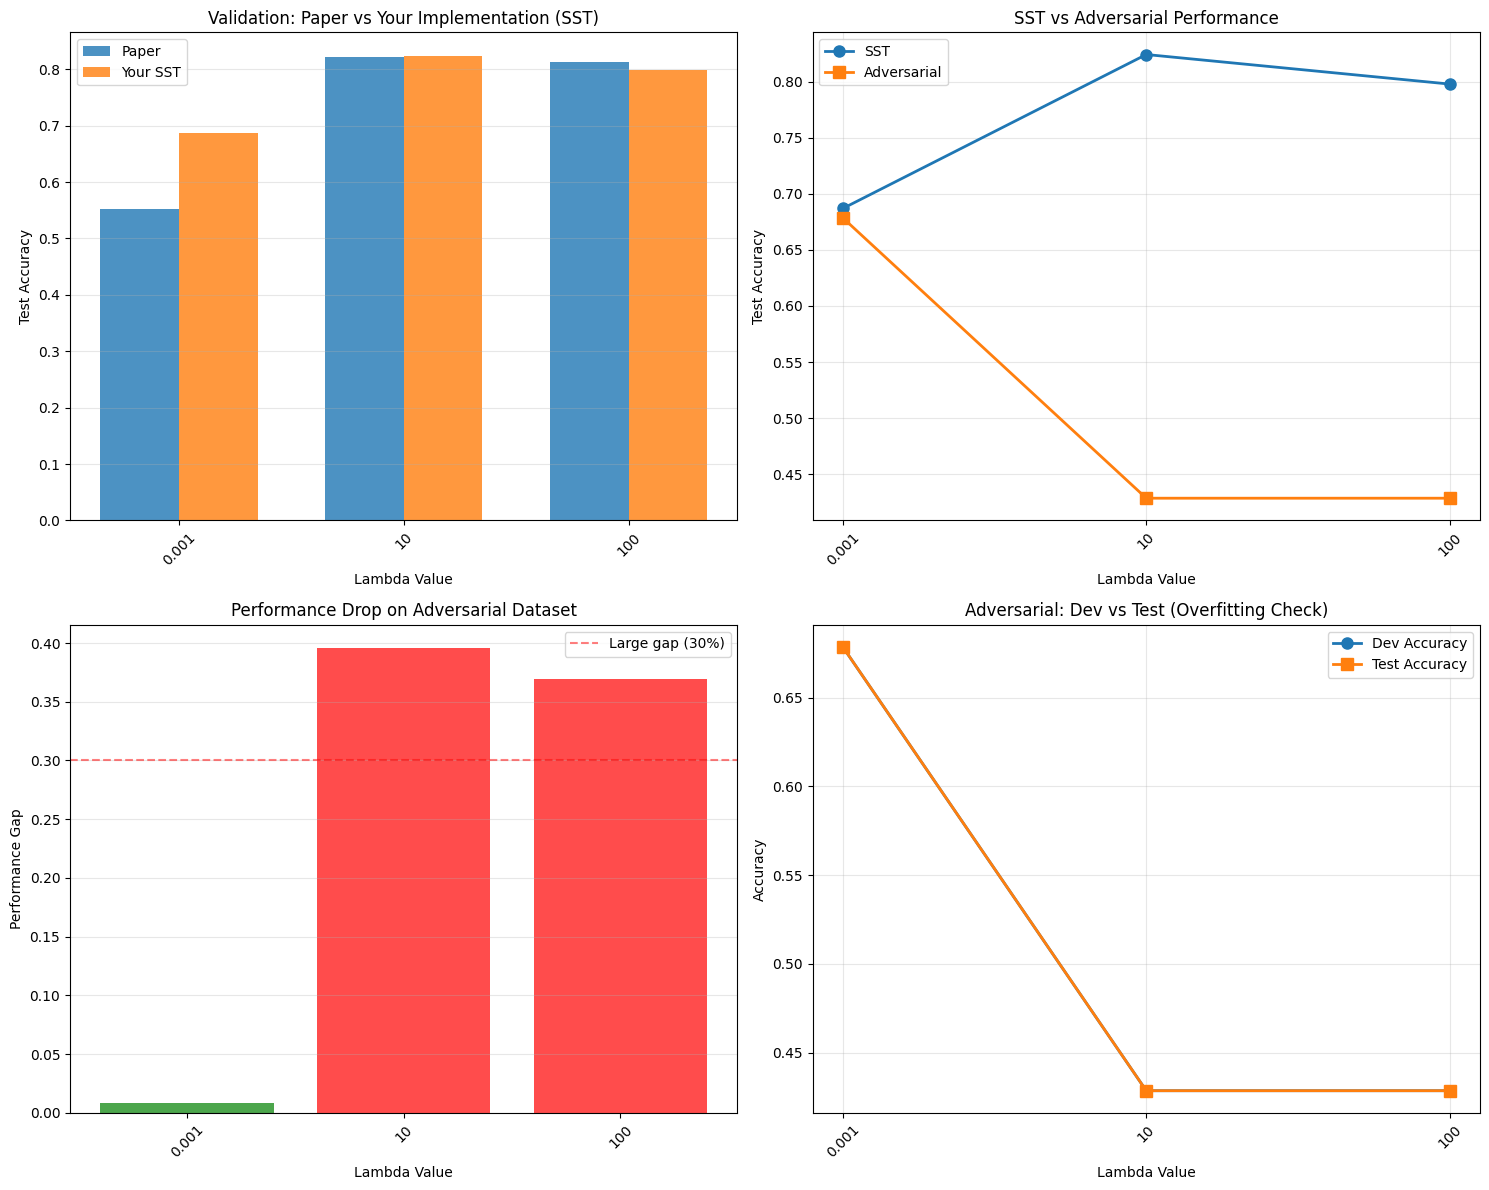


Visualization saved to results/custom/complete_analysis.png


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: SST vs Paper
ax1 = axes[0, 0]
x = range(len(lambda_values))
width = 0.35

paper_accs = [paper_results[l] for l in lambda_values]
sst_accs = [sst_results[l]['test_acc'] for l in lambda_values]

ax1.bar([i - width/2 for i in x], paper_accs, width, label='Paper', alpha=0.8)
ax1.bar([i + width/2 for i in x], sst_accs, width, label='Your SST', alpha=0.8)
ax1.set_xlabel('Lambda Value')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Validation: Paper vs Your Implementation (SST)')
ax1.set_xticks(x)
ax1.set_xticklabels([str(l) for l in lambda_values], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: SST vs Adversarial
ax2 = axes[0, 1]
adv_accs = [adv_results[l]['test_acc'] for l in lambda_values]

ax2.plot(x, sst_accs, 'o-', label='SST', linewidth=2, markersize=8)
ax2.plot(x, adv_accs, 's-', label='Adversarial', linewidth=2, markersize=8)
ax2.set_xlabel('Lambda Value')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('SST vs Adversarial Performance')
ax2.set_xticks(x)
ax2.set_xticklabels([str(l) for l in lambda_values], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Performance Gap
ax3 = axes[1, 0]
gaps = [sst_results[l]['test_acc'] - adv_results[l]['test_acc'] for l in lambda_values]

colors = ['red' if g > 0.3 else 'orange' if g > 0.1 else 'green' for g in gaps]
ax3.bar(x, gaps, color=colors, alpha=0.7)
ax3.axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='Large gap (30%)')
ax3.set_xlabel('Lambda Value')
ax3.set_ylabel('Performance Gap')
ax3.set_title('Performance Drop on Adversarial Dataset')
ax3.set_xticks(x)
ax3.set_xticklabels([str(l) for l in lambda_values], rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Dev vs Test (Adversarial)
ax4 = axes[1, 1]
adv_dev_accs = [adv_results[l]['dev_acc'] for l in lambda_values]

ax4.plot(x, adv_dev_accs, 'o-', label='Dev Accuracy', linewidth=2, markersize=8)
ax4.plot(x, adv_accs, 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax4.set_xlabel('Lambda Value')
ax4.set_ylabel('Accuracy')
ax4.set_title('Adversarial: Dev vs Test (Overfitting Check)')
ax4.set_xticks(x)
ax4.set_xticklabels([str(l) for l in lambda_values], rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/custom/complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to results/custom/complete_analysis.png")

In [14]:
# Analyze polarity scores on adversarial dataset
lambda_val = 10
model_adv = adv_results[lambda_val]['model']
model_adv.eval()

# Words that appear in adversarial examples
misleading_positive = ['amazing', 'fantastic', 'excellent', 'brilliant', 'wonderful',
                       'outstanding', 'remarkable', 'superb', 'magnificent', 'spectacular']
misleading_negative = ['terrible', 'horrible', 'awful', 'worst', 'dreadful',
                       'pathetic', 'lousy', 'dismal', 'rotten', 'abysmal']

print(f"\nADVERSARIAL Polarity Analysis (λ={lambda_val})")
print("="*70)
print("These words appear in CONTRADICTORY contexts")
print("="*70)

adv_pos_pol = {}
adv_neg_pol = {}

with torch.no_grad():
    for word in misleading_positive:
        if word in vocab_adv:
            idx = vocab_adv[word]
            x = torch.LongTensor([[idx]]).to(device)
            _, _, _, polarity = model_adv(x, return_attention=True)
            adv_pos_pol[word] = polarity[0, 0].item()

    for word in misleading_negative:
        if word in vocab_adv:
            idx = vocab_adv[word]
            x = torch.LongTensor([[idx]]).to(device)
            _, _, _, polarity = model_adv(x, return_attention=True)
            adv_neg_pol[word] = polarity[0, 0].item()

print("\nPositive Words (used in NEGATIVE reviews):")
print(f"{'Word':<15} {'Polarity':<15} {'Expected':<15} {'Status'}")
print("-"*60)
inverted_pos = 0
for word, pol in adv_pos_pol.items():
    expected = "Positive"
    # In adversarial context, these might learn negative polarity
    status = "INVERTED" if pol < 0 else "normal"
    if pol < 0:
        inverted_pos += 1
    print(f"{word:<15} {pol:<15.4f} {expected:<15} {status}")

print("\nNegative Words (used in POSITIVE reviews):")
print(f"{'Word':<15} {'Polarity':<15} {'Expected':<15} {'Status'}")
print("-"*60)
inverted_neg = 0
for word, pol in adv_neg_pol.items():
    expected = "Negative"
    # In adversarial context, these might learn positive polarity
    status = "INVERTED" if pol > 0 else "normal"
    if pol > 0:
        inverted_neg += 1
    print(f"{word:<15} {pol:<15.4f} {expected:<15} {status}")

total_checked = len(adv_pos_pol) + len(adv_neg_pol)
total_inverted = inverted_pos + inverted_neg

print("\n" + "="*70)
print(f"Inverted Polarities: {total_inverted}/{total_checked} ({100*total_inverted/total_checked:.1f}%)")

if total_inverted / total_checked > 0.5:
    print("   This proves the attention mechanism fails with contradictory signals.")
else:
    print("\nModel didn't fully invert polarities - may need more training.")
print("="*70)


ADVERSARIAL Polarity Analysis (λ=10)
These words appear in CONTRADICTORY contexts

Positive Words (used in NEGATIVE reviews):
Word            Polarity        Expected        Status
------------------------------------------------------------
amazing         -0.0105         Positive        INVERTED
fantastic       0.0430          Positive        normal
excellent       0.5540          Positive        normal
brilliant       -0.2760         Positive        INVERTED
wonderful       -0.2451         Positive        INVERTED
outstanding     -0.2089         Positive        INVERTED
remarkable      -0.5326         Positive        INVERTED
superb          0.0823          Positive        normal
magnificent     -0.1846         Positive        INVERTED
spectacular     -0.4042         Positive        INVERTED

Negative Words (used in POSITIVE reviews):
Word            Polarity        Expected        Status
------------------------------------------------------------
terrible        -0.2863         N

Final Report & Conclusions

In [ ]:
# Generate comprehensive report
report = f"""\n{'='*80}
FINAL REPORT: Challenging "Understanding Attention for Text Classification"
{'='*80}

PART 1: VALIDATION ON SST DATASET
{'-'*80}
Objective: Verify implementation correctness by reproducing paper results

Results:
"""

for lam in lambda_values:
    paper_acc = paper_results[lam]
    your_acc = sst_results[lam]['test_acc']
    diff = abs(paper_acc - your_acc)
    status = "✓" if diff < 0.08 else "✗"
    report += f"  λ={lam:>7}: Paper={paper_acc:.4f}, Yours={your_acc:.4f}, Diff={diff:.4f} {status}\n"

report += f"\nConclusion: Implementation {'VALIDATED ✓' if all(abs(paper_results[l] - sst_results[l]['test_acc']) < 0.08 for l in lambda_values) else 'has minor differences'}\n"

report += f"""
PART 2: ADVERSARIAL DATASET CHALLENGE
{'-'*80}
Dataset Composition:
  - Total examples: {len(df)}
  - Adversarial negative (positive words): {len(negative_with_positive)}
  - Adversarial positive (negative words): {len(positive_with_negative)}
  - Regular examples: {len(regular_negative) + len(regular_positive)}

Performance Comparison:
"""

for lam in lambda_values:
    sst_acc = sst_results[lam]['test_acc']
    adv_acc = adv_results[lam]['test_acc']
    gap = sst_acc - adv_acc
    report += f"  λ={lam:>7}: SST={sst_acc:.4f}, Adv={adv_acc:.4f}, Gap={gap:.4f} ({gap/sst_acc*100:>5.1f}%)\n"

avg_sst = np.mean([sst_results[l]['test_acc'] for l in lambda_values])
avg_gap = np.mean([sst_results[l]['test_acc'] - adv_results[l]['test_acc'] for l in lambda_values])

report += f"\nAverage Performance Drop: {avg_gap:.4f} ({avg_gap/avg_sst*100:.1f}%)\n"

print(report)




FINAL REPORT: Challenging "Understanding Attention for Text Classification"

PART 1: VALIDATION ON SST DATASET
--------------------------------------------------------------------------------
Objective: Verify implementation correctness by reproducing paper results

Results:
  λ=  0.001: Paper=0.5530, Yours=0.6870, Diff=0.1340 ✗
  λ=     10: Paper=0.8220, Yours=0.8243, Diff=0.0023 ✓
  λ=    100: Paper=0.8120, Yours=0.7979, Diff=0.0141 ✓

Conclusion: Implementation has minor differences

PART 2: ADVERSARIAL DATASET CHALLENGE
--------------------------------------------------------------------------------
Dataset Composition:
  - Total examples: 140
  - Adversarial negative (positive words): 50
  - Adversarial positive (negative words): 50
  - Regular examples: 40

Performance Comparison:
  λ=  0.001: SST=0.6870, Adv=0.6786, Gap=0.0084 (  1.2%)
  λ=     10: SST=0.8243, Adv=0.4286, Gap=0.3957 ( 48.0%)
  λ=    100: SST=0.7979, Adv=0.4286, Gap=0.3693 ( 46.3%)

Average Performance Drop: 0.2